In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/rockley

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/rockley


In [2]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import utils.data as data_loader
 
train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=32,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

Yclass_train = (Ytrain < 80).astype(int)
Yclass_val = (Yval < 80).astype(int)

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

clf = LogisticRegression(C=2, max_iter=400)
clf.fit(Xtrain, Yclass_train)
predicted = clf.predict(Xval)
print("Accuracy:", np.mean(predicted == Yclass_val))

prob_predict = clf.predict_proba(Xval)
print("AUC:", sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

Accuracy: 0.93428125
AUC: 0.9857552938052028


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Cut out

In [ ]:
import utils.data as data_loader
 
train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=32,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

Yclass_train = (Ytrain < 80).astype(int)
Yclass_val = (Yval < 80).astype(int)
Yclass_test = (Ytest < 80).astype(int)

In [ ]:
# Subsample data for faster training, results don't differ much between two
subindex = 10000
# subindex = len(Xtrain)

Xtrain_sub = Xtrain[:subindex]
Ytrain_sub = Yclass_train[:subindex]

In [ ]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

clf = LogisticRegression(C=50, max_iter=3000)
clf.fit(Xtrain_sub, Ytrain_sub)
predicted = clf.predict(Xval)
print("Accuracy:", np.mean(predicted == Yclass_val))

prob_predict = clf.predict_proba(Xval)
print("AUC:", sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1]))

Accuracy: 0.9741875
AUC: 0.9976003563722897


In [ ]:
idxs = []

# Save indices
# idxs = [102, 50, 91, 115, 78, 2, 116, 97, 6, 191, 5, 1, 14, 7, 182, 55, 98, 192, 4, 190, 61, 56, 87, 8, 13, 52, 189, 175, 151, 174, 66, 75, 188, 77, 187, 0, 157, 19, 67, 176, 96, 18, 173, 156, 70, 76, 9, 79, 16, 65, 74, 186, 69, 17, 10, 178, 20, 54, 73, 15]

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

# Subindex for speed if needed (this is effectively random because our data_loader shuffles the data first)
subindex = 10000
# Don't need it but will be much slower, and results don't differ greatly for large enough subindex
# subindex = len(Xsub_train)

added_idxs = idxs[::]
added_set = set(added_idxs)
mse_losses = []
for i in range(len(added_idxs), 60):
  if i % 10 == 0:
    print(i)

  best = -1
  best_val = 0
  for j in range(197):
    if j not in added_set:
      cut = added_idxs + [j]
      Xcut = Xtrain_sub[:subindex, cut]

      reg = LogisticRegression(C=5, max_iter=1000)
      reg.fit(Xcut, Yclass_train[:subindex])
      prob_predict = reg.predict_proba(Xcut)
      auc = sklearn.metrics.roc_auc_score(Yclass_train[:subindex], prob_predict[:, 1])

      if auc > best_val:
        best = j
        best_val = auc
    
  added_set.add(best)
  added_idxs.append(best)
  mse_losses.append(best_val)

40
50


In [ ]:
print(added_idxs)
print(len(added_idxs))

[102, 50, 91, 115, 78, 2, 116, 97, 6, 191, 5, 1, 14, 7, 182, 55, 98, 192, 4, 190, 61, 56, 87, 8, 13, 52, 189, 175, 151, 174, 66, 75, 188, 77, 187, 0, 157, 19, 67, 176, 96, 18, 173, 156, 70, 76, 9, 79, 16, 65, 74, 186, 69, 17, 10, 178, 20, 54, 73, 15]
60


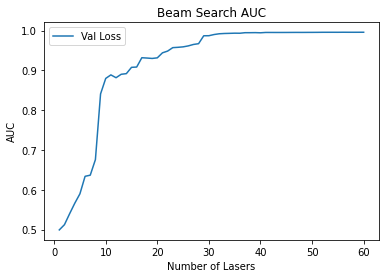

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

val_losses = []
train_losses = []
for i in range(len(idxs)):
  reg = LogisticRegression(C=50, max_iter=3000)
  reg.fit(Xtrain_sub[:, idxs[:i + 1]], Ytrain_sub)

  prob_predict = reg.predict_proba(Xtrain[:, idxs[:i + 1]])
  auc = sklearn.metrics.roc_auc_score(Yclass_train, prob_predict[:, 1])
  train_losses.append(auc)
  prob_predict = reg.predict_proba(Xval[:, idxs[:i + 1]])
  auc = sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1])
  val_losses.append(auc)

plt.plot(range(1, len(idxs) + 1), val_losses)
plt.title("Beam Search AUC")
plt.ylabel("AUC")
plt.xlabel("Number of Lasers")
plt.legend(["Val Loss"])
plt.show()

In [ ]:
reg = LogisticRegression(C=50, max_iter=3000)
reg.fit(Xtrain[:, idxs[:30]], Yclass_train)

prob_predict = reg.predict_proba(Xtest[:, idxs[:30]])
auc = sklearn.metrics.roc_auc_score(Yclass_test, prob_predict[:, 1])
print("AUC:", auc)

predicted = reg.predict(Xtest[:, idxs[:30]])
print("Accuracy:", np.mean(predicted == Yclass_test))


AUC: 0.9942790147843044
Accuracy: 0.959275


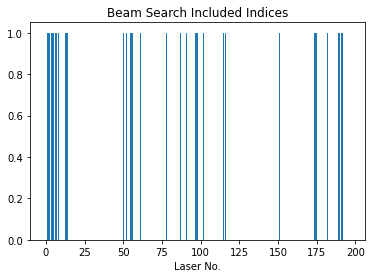

In [6]:
class_idxs = [102, 50, 91, 115, 78, 2, 116, 97, 6, 191, 5, 1, 14, 7, 182, 55, 98, 192, 4, 190, 61, 56, 87, 8, 13, 52, 189, 175, 151, 174, 66, 75, 188, 77, 187, 0, 157, 19, 67, 176, 96, 18, 173, 156, 70, 76, 9, 79, 16, 65, 74, 186, 69, 17, 10, 178, 20, 54, 73, 15]
class_idxs =  class_idxs[:30]

class_present = [1 if x in class_idxs else 0 for x in range(197)]

plt.bar([x for x in range(len(class_present))], class_present)
plt.title("Beam Search Included Indices")
plt.xlabel("Laser No.")
plt.show()

# Noisify

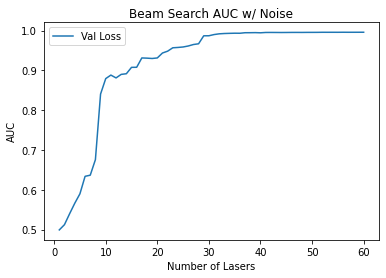

In [ ]:
idxs = [102, 50, 91, 115, 78, 2, 116, 97, 6, 191, 5, 1, 14, 7, 182, 55, 98, 192, 4, 190, 61, 56, 87, 8, 13, 52, 189, 175, 151, 174, 66, 75, 188, 77, 187, 0, 157, 19, 67, 176, 96, 18, 173, 156, 70, 76, 9, 79, 16, 65, 74, 186, 69, 17, 10, 178, 20, 54, 73, 15]

train, val, test = data_loader.load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=32,
    noise=1e-5
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

Yclass_train = (Ytrain < 80).astype(int)
Yclass_val = (Yval < 80).astype(int)

import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

subindex = 10000
# subindex = len(Xtrain)

noisy_val_losses = []
for i in range(len(idxs)):
  reg = LogisticRegression(C=50, max_iter=3000)
  reg.fit(Xtrain[:subindex, idxs[:i + 1]], Yclass_train[:subindex])

  prob_predict = reg.predict_proba(Xval[:, idxs[:i + 1]])
  auc = sklearn.metrics.roc_auc_score(Yclass_val, prob_predict[:, 1])
  noisy_val_losses.append(auc)

plt.plot(range(1, len(idxs) + 1), noisy_val_losses)
plt.title("Beam Search AUC w/ Noise")
plt.ylabel("AUC")
plt.xlabel("Number of Lasers")
plt.legend(["Val Loss"])
plt.show()

In [ ]:
reg = LogisticRegression(C=50, max_iter=3000)
reg.fit(Xtrain[:, idxs[:30]], Yclass_train)

prob_predict = reg.predict_proba(Xtest[:, idxs[:30]])
auc = sklearn.metrics.roc_auc_score(Yclass_test, prob_predict[:, 1])
print("AUC:", auc)

predicted = reg.predict(Xtest[:, idxs[:30]])
print("Accuracy:", np.mean(predicted == Yclass_test))


AUC: 0.9940714294574526
Accuracy: 0.9579
